# Monte Carlo Methods In Finance: A Modern Portfolio Theory Example

## Goal

The goal of this note is to use modern portfolio theory and Monte Carlo methods to explore the performance of various equity portfolios from 2016 to 2018.

## Summary

Modern portfolio theory (MPT) is an investment model that focuses on the natural relationship/trade-off between expected return and volatility. After generating a large set of possibilities, an optimal portfolio is selected that maximizes the investor's expected return given an accepted level of volatility.

Each portfolio in the collection is constructed by assigning various weights to the asset classes under consideration and then evaluating the resulting portfolio's performance (return and volatility) on historical data. For example, we might expect the performance of a portfolio with 30% equity, 50% bonds, and 20% real estate to differ from a portfolio with 80% equity, 10% bonds, and 10% real estate. 

While most real-life applications of MPT would involve a wider variety of investment types, we will be content to work with the S&P 500 (courtesy of the Alpha Vantage API) and use its 11 sectors as the asset classes to be chosen from. The evaluation window for portfolio performance will be January 2016 to December 2018.

The overall process of taking repeated samples and then performing some type of follow-up analysis falls under the heading of Monte Carlo methods. These methods have many applications in finance as well as other disciplines, and the curious reader is encouraged to explore them at their leisure.

## References

* B. Brenyah. [Markowitz's Efficient Frontier in Python](https://medium.com/python-data/effient-frontier-in-python-34b0c3043314). 2017.
* E. Elton, et al. [Modern Portfolio Theory and Investment Analysis](https://www.amazon.com/Modern-Portfolio-Theory-Investment-Analysis/dp/1118469941/ref=sr_1_5?keywords=modern+portfolio+theory&qid=1557492033&s=gateway&sr=8-5). Wiley. 2014.
* A. Rencher and G. Schaalje. [Linear Models in Statistics](https://www.amazon.com/Linear-Models-Statistics-Alvin-Rencher/dp/0471754986). Wiley-Interscience. 2008.





## Importing the Data

After importing the usual libraries for data analysis and visualization, we bring in the data. All equity pricing information was obtained using the Alpha Vantage API.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
equity_data = glob.glob('*prices.csv')
equity_data

['commservices_equity_prices.csv',
 'consdisc_equity_prices.csv',
 'constaples_equity_prices.csv',
 'energy_equity_prices.csv',
 'financials_equity_prices.csv',
 'healthcare_equity_prices.csv',
 'industrials_equity_prices.csv',
 'infotech_equity_prices.csv',
 'materials_equity_prices.csv',
 'realestate_equity_prices.csv',
 'utilities_equity_prices.csv']

In [3]:
sectors = ['Communication Services','Consumer Discretionary','Consumer Staples','Energy',
          'Financials','Health Care','Industrials','Information Technology','Materials','Real Estate','Utilities']

for i in range(len(equity_data)):
    equity_data[i] = pd.read_csv(equity_data[i],index_col=0).dropna(axis=1).loc['2016-01-01':'2018-12-31']
    equity_data[i][str(sectors[i])] = equity_data[i].mean(axis=1)
    
equities = pd.concat(equity_data,axis=1,keys=sectors)
equities = equities.pct_change()
equities = equities[1:]
equities.columns.names = ['Sector','Ticker']

The above code gives us a DataFrame whose columns are individual equities, broken down by GICS Sector (Healthcare, Financials, Industrials, and so on). Moreover, we make a column for each sector denoting the overall returns each day. It's worth pointing out that we only work with equities that were traded each day in the 2016-2018 period. As a result, our bottom-line results are somewhat biased by only including those equities that "made it" to the end.

In [4]:
equities.head()

Sector     Communication Services                                          \
Ticker                       ATVI         T       CTL     CMCSA      DISH   
2016-01-05              -0.012759  0.006987 -0.004779  0.000180  0.001047   
2016-01-06              -0.009424 -0.015322 -0.010804 -0.007727 -0.022493   
2016-01-07              -0.014134 -0.016148 -0.020227 -0.011047 -0.021406   
2016-01-08              -0.015440  0.000895 -0.010322  0.001007 -0.019140   
2016-01-11               0.014002  0.012224  0.006258  0.001006 -0.010593   

Sector                                                          ...     \
Ticker            EA       IPG       OMC      TTWO       DIS    ...      
2016-01-05 -0.017549  0.019281  0.005301  0.016974 -0.020198    ...      
2016-01-06 -0.019403 -0.016767 -0.027312 -0.021295 -0.005352    ...      
2016-01-07 -0.019158 -0.031045 -0.019878 -0.046751 -0.008569    ...      
2016-01-08  0.010727 -0.004964 -0.008651 -0.002468 -0.002513    ...      
2016-01-11  0.017108 -0.005442 -0.003577  0.013296  0.006751    ...      

Sector     Utilities                                                    \
Ticker            FE       NEE        NI       PNW       PPL       PEG   
2016-01-05  0.001270  0.009752  0.015881  0.004994  0.010689  0.005943   
2016-01-06  0.009829 -0.003251  0.005547  0.001398 -0.003231 -0.008220   
2016-01-07 -0.026688  0.004413 -0.022066 -0.000310 -0.011494  0.005180   
2016-01-08  0.019032  0.004489 -0.001538 -0.006980 -0.004472 -0.010049   
2016-01-11  0.015195  0.003898  0.016436  0.011871  0.014975  0.004685   

Sector                                              
Ticker            SO       WEC       XEL Utilities  
2016-01-05  0.007017  0.010717  0.010084  0.007523  
2016-01-06  0.000211 -0.002699  0.010538  0.000083  
2016-01-07 -0.008444 -0.000193  0.003842 -0.005379  
2016-01-08 -0.007452 -0.004834 -0.010935 -0.000382  
2016-01-11  0.004719  0.008160  0.008015  0.005734  

[5 rows x 365 columns]

### Getting Sector-Level Data

Instead of choosing individual equities to include in our portfolios below, we will choose from the 11 sectors of the S&P 500. Having already constructed the sector returns in the previous step, we simply isolate them into their own DataFrame below.

In [5]:
by_sect = pd.concat([equities[sector].iloc[:,-1] for sector in sectors],axis=1)
by_sect.head()

,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
2016-01-05,-0.004160,0.002663,0.006327,0.003862,0.000738,0.002055,0.001095,-0.002531,-0.000284,0.018705,0.007523
2016-01-06,-0.015408,-0.015293,-0.005114,-0.053252,-0.019406,-0.006485,-0.015505,-0.016350,-0.025025,-0.005213,0.000083
2016-01-07,-0.018391,-0.015910,-0.009422,-0.025052,-0.028775,-0.024409,-0.025586,-0.027526,-0.022607,-0.014695,-0.005379
2016-01-08,-0.004393,-0.018297,-0.005565,-0.011897,-0.016568,-0.012919,-0.010457,-0.013012,-0.009656,-0.014112,-0.000382
2016-01-11,0.004822,0.008667,0.004984,-0.026803,0.000324,-0.016136,-0.002923,0.003462,-0.004645,0.005758,0.005734


In [6]:
by_sect.describe()

,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000
mean,0.000121,0.000355,0.000009,0.000091,0.000314,0.000235,0.000435,0.000626,0.000355,-0.000065,0.000359
std,0.010744,0.009760,0.008050,0.015270,0.010791,0.009828,0.009487,0.010946,0.010123,0.009454,0.008981
min,-0.060517,-0.036282,-0.071918,-0.054166,-0.064639,-0.043821,-0.043833,-0.045498,-0.041134,-0.040995,-0.045661
25%,-0.004438,-0.004418,-0.003968,-0.007177,-0.004923,-0.004366,-0.003746,-0.004561,-0.005254,-0.005245,-0.004307
50%,0.000145,0.000953,0.000366,0.000031,0.000798,0.000880,0.000937,0.001397,0.001090,0.000373,0.001045
75%,0.006004,0.005801,0.004596,0.008227,0.005929,0.005631,0.005736,0.006383,0.005811,0.005592,0.005659
max,0.046602,0.056886,0.032357,0.075875,0.045279,0.048270,0.043905,0.053081,0.045995,0.031326,0.028010


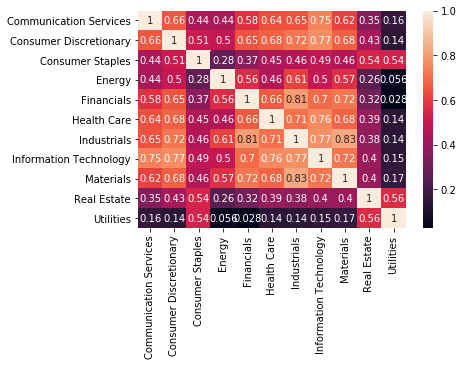

In [7]:
sns.heatmap(by_sect.corr(),annot=True)

### Getting the Risk-Free Rate

An important part of evaluating a given portfolio is comparing its return to the "risk-free" rate of return. For the purposes of this application, our risk-free rate will come from the average 1 Year Treasury Rate from 2016-2018. This data was obtained from [Macrotrends](https://www.macrotrends.net/2492/1-year-treasury-rate-yield-chart).

In [8]:
risk_free = pd.read_csv('treasury_rates.csv',index_col=0)
risk_free = risk_free.loc['2016-01-01':'2018-12-31']
risk_free.head()

,Treasury Rate
date,
2016-01-04,0.61
2016-01-05,0.68
2016-01-06,0.67
2016-01-07,0.66
2016-01-08,0.64


In [9]:
risk_free_rate = risk_free.mean()[0] / 100
risk_free_rate

0.013680546875000008

## Performing the Simulation

Having organized our data, we are now in a position to create and run our simulation. As stated earlier, we will want to note the return and the volatility of each portfolio. In selecting the optimal portfolio, however, we will also make use of the Sharpe Ratio:

\begin{align*}
\text{Sharpe Ratio} = \frac{\text{Portfolio Return - Risk-Free Rate}}{\text{Portfolio Volatility}}
\end{align*}

where a portfolio's volatility is just the standard deviation of its returns. 

For our purposes, the optimal portfolio will be the one with the largest Sharpe Ratio. This makes intuitive sense, as the optimal portfolio should be one that strikes a balance between having a large enough return (big numerator) while also maintaining a reasonable level of volatility (small denominator).

Note: The function below is inspired in part by the [Brenyah](https://medium.com/python-data/effient-frontier-in-python-34b0c3043314) piece cited previously.

In [10]:
def Stock_Market_Monte_Carlo(data, sectors, num_portfolios=100):
        
    # Create the column headers for the DataFrame in which we will store our results    
    headers = ['Annual Return','Volatility','Sharpe Ratio']
    headers.extend([sector for sector in sectors])
    
    # Create the DataFrame in which we will store our results
    returns_and_volatility = pd.DataFrame(columns=headers)
    
    for i in range(num_portfolios):
        np.random.seed(i) # Included for reproducibility
        
        # Generate the weights that will be assigned to each sector in the portfolio
        weights = np.random.random(len(sectors))
        weights /= np.sum(weights)
        
        # Given the assigned weights, calculate the portfolio's return, volatility, and Sharpe ratio
        # The *250's allow us to work with annual returns as opposed to daily returns
        # This is an admittedly crude adjustment, but it serves our purposes
        annual_returns = np.dot(weights,data[sectors].mean()*250)
        volatility = np.sqrt(np.dot(weights.T, np.dot(data[sectors].cov()*250,weights)))
        sharpe_ratio = (annual_returns - risk_free_rate) / volatility
        
        # Add the portfolio's performance and weights to the DataFrame
        values = [annual_returns,volatility,sharpe_ratio]
        values.extend([weight for weight in weights])
        new_row = pd.DataFrame([values],
                               columns=headers)
        returns_and_volatility = returns_and_volatility.append(new_row,ignore_index=True)
    
    return returns_and_volatility

results = Stock_Market_Monte_Carlo(data=by_sect, sectors = ['Consumer Staples','Information Technology',
                                                            'Financials'], num_portfolios=5000)

### Analyzing the Results

We begin by observing the first few portfolios generated by the simulation. We then single out two portfolios: the one with the lowest volatility, and the one with the highest Sharpe ratio.

In [11]:
results.head()

,Annual Return,Volatility,Sharpe Ratio,Consumer Staples,Information Technology,Financials
0,0.085958,0.133763,0.540340,0.293992,0.383117,0.322892
1,0.099926,0.138607,0.622234,0.366625,0.633274,0.000101
2,0.047653,0.127292,0.266885,0.431002,0.025629,0.543368
3,0.087034,0.132073,0.555402,0.355388,0.456914,0.187699
4,0.066020,0.127263,0.411269,0.388842,0.220042,0.391116


In [12]:
max_sharpe_port = results[results['Sharpe Ratio'] == results['Sharpe Ratio'].max()]
max_sharpe_port.index = [0]
min_var_port = results[results['Volatility'] == results['Volatility'].min()]
min_var_port.index = [0]

It is often useful and instructive to plot out the portfolios in terms of their risks/returns. Running the simulation with a sufficiently large sample size should result in the data appearing in a region bounded by a curve (a hyperbola, for those keeping track at home). This curve is known as the "Efficient Frontier." All portfolios on the top side of the frontier are optimal, given their level of volatility.

Note: Because of the specific nature of the equity data used in this simulation, many combinations of sectors may lead to results that are not as "curvy" as might be expected.

Text(0.5,1,'Efficient Frontier')

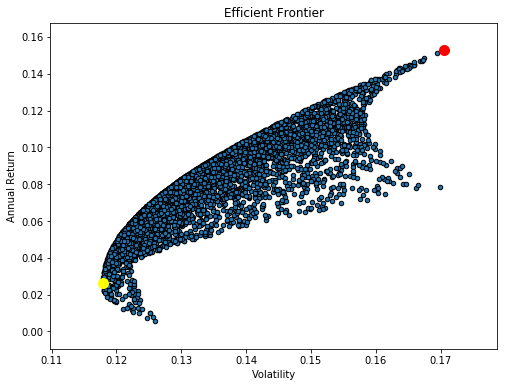

In [13]:
results.plot.scatter(x='Volatility', y='Annual Return',
                     edgecolors='black', figsize=(8, 6))
plt.scatter(x=max_sharpe_port['Volatility'], y=max_sharpe_port['Annual Return'], c='red', marker='o', s=100)
plt.scatter(x=min_var_port['Volatility'], y=min_var_port['Annual Return'], c='yellow', marker='o', s=100 )
plt.xlabel('Volatility')
plt.ylabel('Annual Return')
plt.title('Efficient Frontier')

Here are the specifics of the portfolio with the lowest volatility:

In [14]:
min_var_port

,Annual Return,Volatility,Sharpe Ratio,Consumer Staples,Information Technology,Financials
0,0.026449,0.117963,0.108244,0.704149,0.020544,0.275307


Here are the specifics of the portfolio with the highest Sharpe ratio.

In [15]:
max_sharpe_port

,Annual Return,Volatility,Sharpe Ratio,Consumer Staples,Information Technology,Financials
0,0.152814,0.170552,0.815784,0.009852,0.963085,0.027063


## Conclusion

We presented a simple example of a Monte Carlo simulation whose purpose was to select an optimal investment portfolio under the MPT framework. It should be noted that what we see above is not the full story. As we've already discussed, one would usually wish to include investments outside of equities. As another example, a more realistic model would allow for additional strategies such as short selling. Time permitting, these intricacies may serve as the starting point for future projects. In any case, we hope you found this example to be interesting and informative.